In [ ]:
!pip install fsspec
!pip install gcsfs
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 9.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 10.3 MB/s 
     |████████████████████████████████| 94 kB 2.1 MB/s 
     |████████████████████████████████| 144 kB 38.2 MB/s 
     |████████████████████████████████| 271 kB 37.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.2 MB/s 
     |████████████████████████████████| 6.6 MB 36.4 MB/s 
     |████████████████████████████████| 596 kB 36.5 MB/s 
     |████████████████████████████████| 101 kB 10.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s "/content/drive/My Drive/Colab Notebooks/tfm"
import sys
sys.path.append('tfm/checkpoints/')
sys.path.append('tfm/outputs/')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tqdm.auto import tqdm
from transformers import (
    AutoTokenizer,
    TFBertForSequenceClassification,
)

In [ ]:
filepath = "../../data/outputs/dataset_2021_paragraph"
filepath = "https://storage.googleapis.com/tfm_aideas_datasets/dataset_2021_paragraph" # Filepath GCloud
filepath = "tfm/outputs/dataset_2021_paragraph" # Filepath COLAB

In [ ]:
#### Código para migrar las labels del dataset original etiquetado al nuevo dataset_2021_paragraph_annotated ####
#### Mejor no ejecutar en COLAB para guardar CSV ####
df_no_labels = pd.read_csv(f"{filepath}.csv", sep=";", index_col=0, parse_dates=["date"])

df_hg = pd.read_csv("tfm/outputs/hg_subdataset_paragraph_etiquetado.csv", sep=";", parse_dates=["date"])
df_rs = pd.read_csv("tfm/outputs/rs_subdataset_paragraph_etiquetado.csv", sep=";", parse_dates=["date"])
df_annotated_labels = pd.concat([df_hg,df_rs]).reset_index(drop=True)

old_columns = ["finanzas_news_s_n", "impacto_news_s_n", "topic", "finanzas_s_n", "impacto_s_n"]
new_columns = ["finanzas_tag_news_s_n", "impacto_tag_news_s_n", "topic_tag_news", "finanzas_tag_s_n", "impacto_tag_s_n"]

notna_indexes = df_annotated_labels.loc[:,old_columns].dropna().index
df_annotated_labels = df_annotated_labels.loc[notna_indexes,:]

for idx, row in df_annotated_labels.iterrows():
    for old_label, new_label in zip(old_columns, new_columns):
        df_no_labels.loc[(df_no_labels.body == row.body) & (df_no_labels.title == row.title), new_label] = df_annotated_labels.loc[idx, old_label]

df_no_labels.to_csv(f"{filepath}_annotated.csv", sep=";")
df_total_labels = df_no_labels.copy()

In [ ]:
df_total_labels = pd.read_csv(f"{filepath}_annotated.csv", sep=";", index_col=0, parse_dates=["date"], low_memory=False)

In [ ]:
#Label finanzas sí es 0 y label finanzas no es 1. Contraintuitivo, se podría hacer un replace para no liarnos a las
#características booleanas que etiquetamos

In [ ]:
# Entrenamos sólo con los que tienen relación con las finanzas
finance_yes = df_total_labels.finanzas_tag_news_s_n == 0
impact_label = df_total_labels.impacto_tag_s_n.isin([0, 1])
dataset_labels = df_total_labels[(impact_label & finance_yes)]
dataset_unlabelled = df_total_labels[~impact_label]

In [ ]:
# Para no entrenar varias veces con los mismos párrafos debido a que hayan sido asignados
# a diferentes tickers
dataset_labels.drop_duplicates(subset=["body"], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
# Muy pocos datos
dataset_labels.impacto_tag_s_n.shape

(445,)

In [ ]:
dataset_labels.impacto_tag_s_n.value_counts()/sum(dataset_labels.impacto_tag_s_n.value_counts())

0.0    0.514607
1.0    0.485393
Name: impacto_tag_s_n, dtype: float64

# Transfer Learning con BETO sin KFold

A continuación se reentrena la última capa únicamente de FinBERT para la clasificación de los topics del dataset de noticias.

In [ ]:
N_LABELS = len(np.unique(dataset_labels.impacto_tag_s_n))

In [ ]:
checkpoint = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/310 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/650 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/242k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

In [ ]:
model = TFBertForSequenceClassification.from_pretrained(checkpoint, num_labels=N_LABELS)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.layers[0].trainable=False

In [ ]:
model.compile(
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
optimizer=Adam(learning_rate=0.0001),
metrics=['accuracy']
)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dataset_labels.body_no_entities, dataset_labels.impacto_tag_s_n, test_size=0.2, random_state=42)

In [ ]:
x_train = tokenizer(x_train.tolist(), padding="max_length", truncation=True, return_tensors="tf")

In [ ]:
x_test = tokenizer(x_test.tolist(), padding="max_length", truncation=True, return_tensors="tf")

In [ ]:
N_EPOCAS = 150

In [ ]:
# filepath_checkpoint = './checkpoints/impacto_tag_s_n/checkpoint'
filepath_checkpoint = 'tfm/checkpoints/impacto_tag_s_n_only_fin/checkpoint' # Filepath COLAB

model_checkpoint_callback = ModelCheckpoint(
    filepath=filepath_checkpoint,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min')

hist = model.fit(
    dict(x_train),
    y_train,
    batch_size=128,
    epochs=N_EPOCAS,
    validation_split=0.1,
    # callbacks=[model_checkpoint_callback]
    callbacks=[model_checkpoint_callback, early_stopping]
    )

Epoch 1/150
3/3 [==============================] - 36s 6s/step - loss: 0.7078 - accuracy: 0.4469 - val_loss: 0.6915 - val_accuracy: 0.5000
Epoch 2/150
3/3 [==============================] - 9s 3s/step - loss: 0.6969 - accuracy: 0.5031 - val_loss: 0.6910 - val_accuracy: 0.4444
Epoch 3/150
3/3 [==============================] - 9s 3s/step - loss: 0.6930 - accuracy: 0.4906 - val_loss: 0.6910 - val_accuracy: 0.4722
Epoch 4/150
3/3 [==============================] - 9s 3s/step - loss: 0.6925 - accuracy: 0.5156 - val_loss: 0.6910 - val_accuracy: 0.4722
Epoch 5/150
3/3 [==============================] - 9s 3s/step - loss: 0.6875 - accuracy: 0.5469 - val_loss: 0.6908 - val_accuracy: 0.5000
Epoch 6/150
3/3 [==============================] - 9s 3s/step - loss: 0.6828 - accuracy: 0.5562 - val_loss: 0.6903 - val_accuracy: 0.5000
Epoch 7/150
3/3 [==============================] - 9s 3s/step - loss: 0.6802 - accuracy: 0.5719 - val_loss: 0.6894 - val_accuracy: 0.4722
Epoch 8/150
3/3 [================

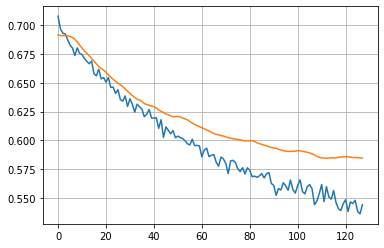

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')
plt.grid()
plt.show()

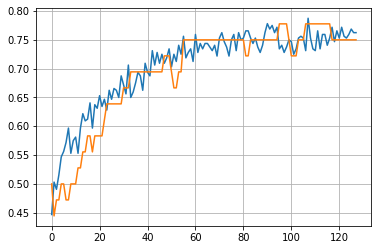

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
model.load_weights(filepath_checkpoint)
model.evaluate(x_test.data, y_test)

3/3 [==============================] - 2s 681ms/step - loss: 0.6023 - accuracy: 0.6629


[0.6022522449493408, 0.6629213690757751]

In [ ]:
# Comparativa con una predicción por clase mayoritaria de train:

pd.Series(y_train).value_counts()/sum(pd.Series(y_train).value_counts())

0.0    0.519663
1.0    0.480337
Name: impacto_tag_s_n, dtype: float64

In [ ]:
y_pred = model.predict(x_test.data)

In [ ]:
y_pred = y_pred.logits.argmax(axis=1)

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.34      0.51        64
           1       0.91      1.00      0.95       407

    accuracy                           0.91       471
   macro avg       0.93      0.67      0.73       471
weighted avg       0.91      0.91      0.89       471



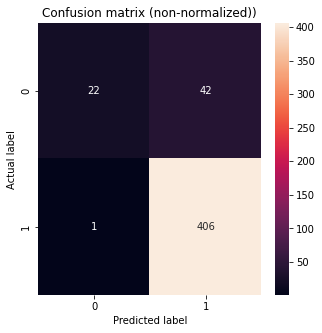

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")


plot_cm(y_test, y_pred)

In [ ]:
def func_apply(row):
    if (not type(row.body_no_entities)==str):    
        row.body_no_entities = str(row.body_no_entities)
    x = tokenizer(row.body_no_entities, padding="max_length", truncation=True, return_tensors="tf")
    y_pred = model.predict(x.data)
    row['impacto_tag_s_n'] = int(y_pred.logits.argmax(axis=1)[0])    
    row['impacto_tag_s_n_proba'] = tf.nn.softmax(y_pred.logits).numpy().max(axis=1)[0]
    return row

In [ ]:
tqdm.pandas()
df_total_labels["impacto_tag_s_n_proba"] = np.NaN
df_total_labels.loc[impact_label, "impacto_tag_s_n_proba"] = 1.
df_total_labels.loc[~impact_label] = df_total_labels.loc[~impact_label].progress_apply(lambda row : func_apply(row), axis=1)

  0%|          | 0/10743 [00:00<?, ?it/s]

In [ ]:
df_total_labels.to_csv(f'{filepath}_predict_impacto_tag_s_n.csv', sep=";")

# Transfer Learning con BETO con KFold

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 1...
Epoch 1/60
12/12 [==============================] - 31s 1s/step - loss: 0.6927 - accuracy: 0.5500 - val_loss: 0.6940 - val_accuracy: 0.5500
Epoch 2/60
12/12 [==============================] - 13s 1s/step - loss: 0.6778 - accuracy: 0.5639 - val_loss: 0.6891 - val_accuracy: 0.5750
Epoch 3/60
12/12 [==============================] - 11s 894ms/step - loss: 0.6726 - accuracy: 0.6139 - val_loss: 0.6868 - val_accuracy: 0.5500
Epoch 4/60
12/12 [==============================] - 13s 1s/step - loss: 0.6639 - accuracy: 0.6306 - val_loss: 0.6856 - val_accuracy: 0.6000
Epoch 5/60
12/12 [==============================] - 11s 895ms/step - loss: 0.6667 - accuracy: 0.6222 - val_loss: 0.6863 - val_accuracy: 0.5750
Epoch 6/60
12/12 [==============================] - 11s 894ms/step - loss: 0.6629 - accuracy: 0.6278 - val_loss: 0.6856 - val_accuracy: 0.5750
Epoch 7/60
12/12 [==============================] - 11s 898ms/step - loss: 0.6568 - accuracy: 0.6278 - val_loss: 0.6824 - val_a

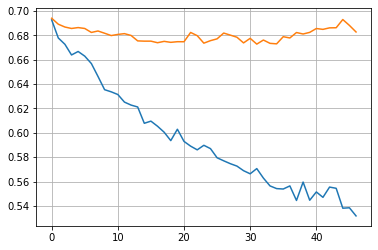

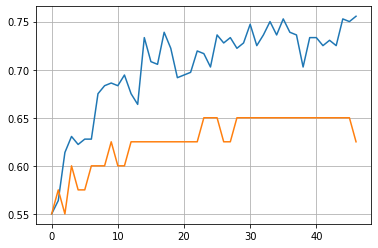

2/2 [==============================] - 1s 344ms/step - loss: 0.6615 - accuracy: 0.6000
Accuracy: 0.6000000238418579


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 2...
Epoch 1/60
12/12 [==============================] - 31s 1s/step - loss: 0.6837 - accuracy: 0.5722 - val_loss: 0.6971 - val_accuracy: 0.4750
Epoch 2/60
12/12 [==============================] - 11s 897ms/step - loss: 0.6788 - accuracy: 0.5639 - val_loss: 0.7021 - val_accuracy: 0.4750
Epoch 3/60
12/12 [==============================] - 11s 892ms/step - loss: 0.6654 - accuracy: 0.6139 - val_loss: 0.7044 - val_accuracy: 0.4750
Epoch 4/60
12/12 [==============================] - 11s 892ms/step - loss: 0.6605 - accuracy: 0.6278 - val_loss: 0.7044 - val_accuracy: 0.4750
Epoch 5/60
12/12 [==============================] - 11s 891ms/step - loss: 0.6516 - accuracy: 0.6306 - val_loss: 0.7074 - val_accuracy: 0.4750
Epoch 6/60
12/12 [==============================] - 11s 892ms/step - loss: 0.6462 - accuracy: 0.6361 - val_loss: 0.7039 - val_accuracy: 0.4750
Epoch 7/60
12/12 [==============================] - 11s 890ms/step - loss: 0.6396 - accuracy: 0.6639 - val_loss: 0.7061 -

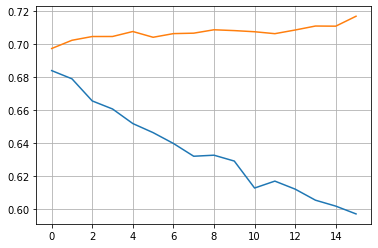

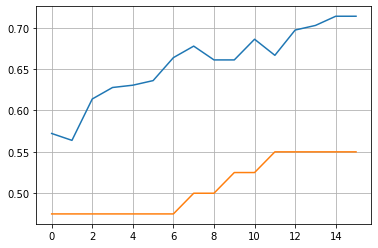

2/2 [==============================] - 1s 344ms/step - loss: 0.6931 - accuracy: 0.5333
Accuracy: 0.5333333611488342


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 3...
Epoch 1/60
12/12 [==============================] - 32s 1s/step - loss: 0.6910 - accuracy: 0.5250 - val_loss: 0.7009 - val_accuracy: 0.4750
Epoch 2/60
12/12 [==============================] - 11s 910ms/step - loss: 0.6746 - accuracy: 0.6167 - val_loss: 0.7121 - val_accuracy: 0.4500
Epoch 3/60
12/12 [==============================] - 11s 892ms/step - loss: 0.6687 - accuracy: 0.6028 - val_loss: 0.7241 - val_accuracy: 0.4500
Epoch 4/60
12/12 [==============================] - 11s 892ms/step - loss: 0.6590 - accuracy: 0.6194 - val_loss: 0.7313 - val_accuracy: 0.4500
Epoch 5/60
12/12 [==============================] - 11s 893ms/step - loss: 0.6563 - accuracy: 0.6139 - val_loss: 0.7286 - val_accuracy: 0.4500
Epoch 6/60
12/12 [==============================] - 11s 892ms/step - loss: 0.6471 - accuracy: 0.6444 - val_loss: 0.7307 - val_accuracy: 0.4500
Epoch 7/60
12/12 [==============================] - 11s 891ms/step - loss: 0.6438 - accuracy: 0.6306 - val_loss: 0.7347 -

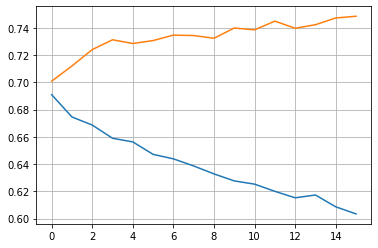

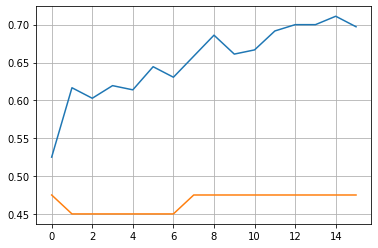

2/2 [==============================] - 1s 343ms/step - loss: 0.6949 - accuracy: 0.5111
Accuracy: 0.5111111402511597


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 4...
Epoch 1/60
12/12 [==============================] - 31s 1s/step - loss: 0.6918 - accuracy: 0.5556 - val_loss: 0.7096 - val_accuracy: 0.3000
Epoch 2/60
12/12 [==============================] - 13s 1s/step - loss: 0.6870 - accuracy: 0.5333 - val_loss: 0.7116 - val_accuracy: 0.4000
Epoch 3/60
12/12 [==============================] - 14s 1s/step - loss: 0.6756 - accuracy: 0.6056 - val_loss: 0.7118 - val_accuracy: 0.4500
Epoch 4/60
12/12 [==============================] - 11s 893ms/step - loss: 0.6729 - accuracy: 0.5861 - val_loss: 0.7140 - val_accuracy: 0.4500
Epoch 5/60
12/12 [==============================] - 13s 1s/step - loss: 0.6716 - accuracy: 0.5972 - val_loss: 0.7138 - val_accuracy: 0.4750
Epoch 6/60
12/12 [==============================] - 13s 1s/step - loss: 0.6651 - accuracy: 0.6139 - val_loss: 0.7073 - val_accuracy: 0.5250
Epoch 7/60
12/12 [==============================] - 11s 895ms/step - loss: 0.6586 - accuracy: 0.6306 - val_loss: 0.7085 - val_accurac

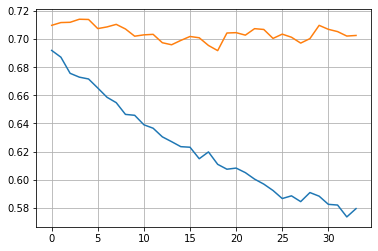

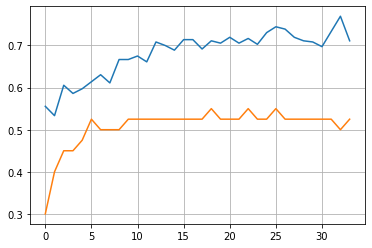

2/2 [==============================] - 1s 341ms/step - loss: 0.5818 - accuracy: 0.7556
Accuracy: 0.7555555701255798


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 5...
Epoch 1/60
12/12 [==============================] - 31s 1s/step - loss: 0.6953 - accuracy: 0.5306 - val_loss: 0.7182 - val_accuracy: 0.4500
Epoch 2/60
12/12 [==============================] - 11s 897ms/step - loss: 0.6808 - accuracy: 0.5556 - val_loss: 0.7217 - val_accuracy: 0.4500
Epoch 3/60
12/12 [==============================] - 11s 891ms/step - loss: 0.6767 - accuracy: 0.5972 - val_loss: 0.7236 - val_accuracy: 0.4500
Epoch 4/60
12/12 [==============================] - 11s 893ms/step - loss: 0.6714 - accuracy: 0.5944 - val_loss: 0.7293 - val_accuracy: 0.4250
Epoch 5/60
12/12 [==============================] - 11s 894ms/step - loss: 0.6646 - accuracy: 0.6056 - val_loss: 0.7326 - val_accuracy: 0.4250
Epoch 6/60
12/12 [==============================] - 11s 893ms/step - loss: 0.6571 - accuracy: 0.6139 - val_loss: 0.7350 - val_accuracy: 0.4250
Epoch 7/60
12/12 [==============================] - 11s 892ms/step - loss: 0.6481 - accuracy: 0.6639 - val_loss: 0.7329 -

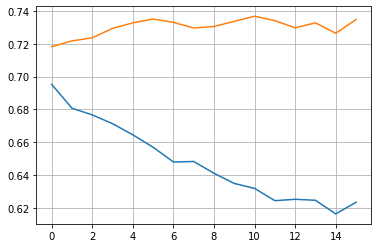

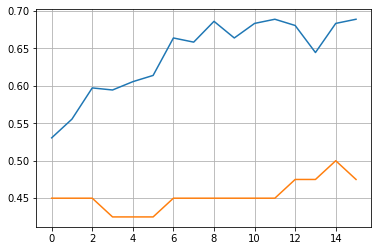

2/2 [==============================] - 1s 351ms/step - loss: 0.6115 - accuracy: 0.7111
Accuracy: 0.7111111283302307


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 6...
Epoch 1/60
12/12 [==============================] - 32s 1s/step - loss: 0.7080 - accuracy: 0.4361 - val_loss: 0.7043 - val_accuracy: 0.4390
Epoch 2/60
12/12 [==============================] - 14s 1s/step - loss: 0.6940 - accuracy: 0.5250 - val_loss: 0.7066 - val_accuracy: 0.5122
Epoch 3/60
12/12 [==============================] - 14s 1s/step - loss: 0.6798 - accuracy: 0.5889 - val_loss: 0.7068 - val_accuracy: 0.5366
Epoch 4/60
12/12 [==============================] - 11s 898ms/step - loss: 0.6862 - accuracy: 0.5861 - val_loss: 0.7081 - val_accuracy: 0.5122
Epoch 5/60
12/12 [==============================] - 11s 895ms/step - loss: 0.6762 - accuracy: 0.5833 - val_loss: 0.7085 - val_accuracy: 0.5122
Epoch 6/60
12/12 [==============================] - 11s 894ms/step - loss: 0.6698 - accuracy: 0.5889 - val_loss: 0.7068 - val_accuracy: 0.5122
Epoch 7/60
12/12 [==============================] - 11s 895ms/step - loss: 0.6656 - accuracy: 0.6194 - val_loss: 0.7080 - val_a

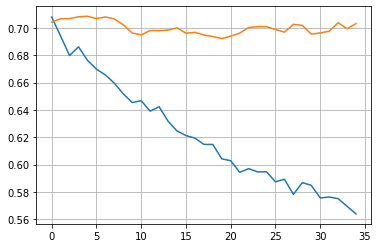

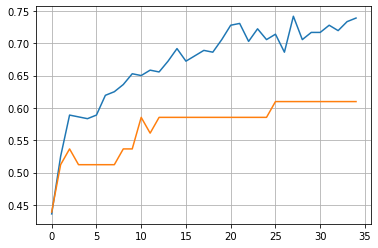

2/2 [==============================] - 1s 326ms/step - loss: 0.6242 - accuracy: 0.6818
Accuracy: 0.6818181872367859


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 7...
Epoch 1/60
12/12 [==============================] - 31s 1s/step - loss: 0.7127 - accuracy: 0.4750 - val_loss: 0.6861 - val_accuracy: 0.5610
Epoch 2/60
12/12 [==============================] - 13s 1s/step - loss: 0.6937 - accuracy: 0.5250 - val_loss: 0.6915 - val_accuracy: 0.5854
Epoch 3/60
12/12 [==============================] - 11s 898ms/step - loss: 0.6760 - accuracy: 0.5917 - val_loss: 0.6967 - val_accuracy: 0.5610
Epoch 4/60
12/12 [==============================] - 11s 895ms/step - loss: 0.6706 - accuracy: 0.5972 - val_loss: 0.7013 - val_accuracy: 0.5366
Epoch 5/60
12/12 [==============================] - 11s 893ms/step - loss: 0.6644 - accuracy: 0.6000 - val_loss: 0.7083 - val_accuracy: 0.5122
Epoch 6/60
12/12 [==============================] - 11s 893ms/step - loss: 0.6570 - accuracy: 0.6194 - val_loss: 0.7044 - val_accuracy: 0.5122
Epoch 7/60
12/12 [==============================] - 11s 893ms/step - loss: 0.6478 - accuracy: 0.6528 - val_loss: 0.6972 - va

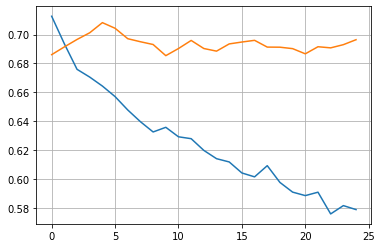

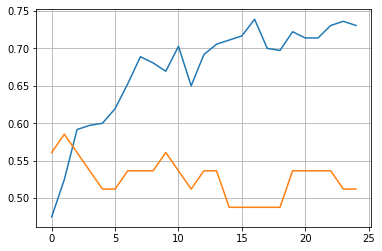

2/2 [==============================] - 1s 327ms/step - loss: 0.6982 - accuracy: 0.4773
Accuracy: 0.47727271914482117


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 8...
Epoch 1/60
12/12 [==============================] - 31s 1s/step - loss: 0.7015 - accuracy: 0.4444 - val_loss: 0.7115 - val_accuracy: 0.4146
Epoch 2/60
12/12 [==============================] - 11s 896ms/step - loss: 0.6976 - accuracy: 0.5111 - val_loss: 0.7113 - val_accuracy: 0.3902
Epoch 3/60
12/12 [==============================] - 11s 894ms/step - loss: 0.6914 - accuracy: 0.5361 - val_loss: 0.7092 - val_accuracy: 0.3415
Epoch 4/60
12/12 [==============================] - 11s 893ms/step - loss: 0.6750 - accuracy: 0.6028 - val_loss: 0.7073 - val_accuracy: 0.3659
Epoch 5/60
12/12 [==============================] - 13s 1s/step - loss: 0.6753 - accuracy: 0.5778 - val_loss: 0.7056 - val_accuracy: 0.4390
Epoch 6/60
12/12 [==============================] - 11s 897ms/step - loss: 0.6651 - accuracy: 0.6333 - val_loss: 0.7043 - val_accuracy: 0.4390
Epoch 7/60
12/12 [==============================] - 13s 1s/step - loss: 0.6610 - accuracy: 0.6417 - val_loss: 0.7035 - val_a

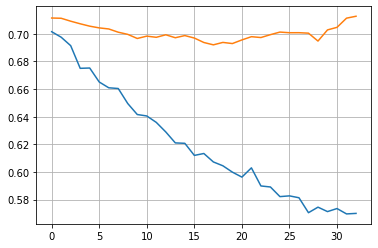

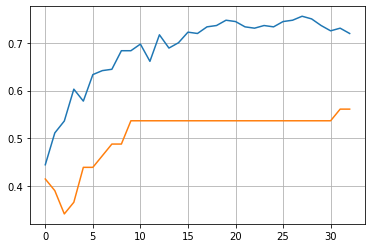

2/2 [==============================] - 1s 332ms/step - loss: 0.5744 - accuracy: 0.7045
Accuracy: 0.7045454382896423


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 9...
Epoch 1/60
12/12 [==============================] - 32s 1s/step - loss: 0.6939 - accuracy: 0.5139 - val_loss: 0.7107 - val_accuracy: 0.4146
Epoch 2/60
12/12 [==============================] - 13s 1s/step - loss: 0.6882 - accuracy: 0.5333 - val_loss: 0.7130 - val_accuracy: 0.4390
Epoch 3/60
12/12 [==============================] - 11s 902ms/step - loss: 0.6783 - accuracy: 0.5861 - val_loss: 0.7144 - val_accuracy: 0.4390
Epoch 4/60
12/12 [==============================] - 11s 896ms/step - loss: 0.6762 - accuracy: 0.6000 - val_loss: 0.7104 - val_accuracy: 0.4146
Epoch 5/60
12/12 [==============================] - 11s 895ms/step - loss: 0.6624 - accuracy: 0.6361 - val_loss: 0.7130 - val_accuracy: 0.4390
Epoch 6/60
12/12 [==============================] - 11s 895ms/step - loss: 0.6587 - accuracy: 0.6111 - val_loss: 0.7121 - val_accuracy: 0.4390
Epoch 7/60
12/12 [==============================] - 13s 1s/step - loss: 0.6531 - accuracy: 0.6611 - val_loss: 0.7091 - val_a

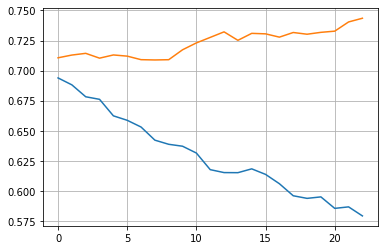

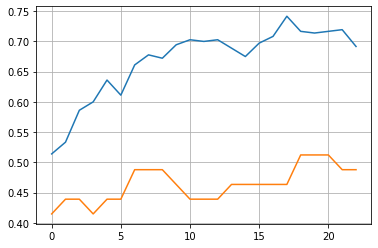

2/2 [==============================] - 1s 330ms/step - loss: 0.6202 - accuracy: 0.6818
Accuracy: 0.6818181872367859


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 10...
Epoch 1/60
12/12 [==============================] - 32s 2s/step - loss: 0.6931 - accuracy: 0.5417 - val_loss: 0.6942 - val_accuracy: 0.5366
Epoch 2/60
12/12 [==============================] - 11s 901ms/step - loss: 0.6860 - accuracy: 0.5528 - val_loss: 0.6920 - val_accuracy: 0.5366
Epoch 3/60
12/12 [==============================] - 11s 895ms/step - loss: 0.6810 - accuracy: 0.5611 - val_loss: 0.6886 - val_accuracy: 0.5366
Epoch 4/60
12/12 [==============================] - 11s 893ms/step - loss: 0.6753 - accuracy: 0.6000 - val_loss: 0.6874 - val_accuracy: 0.5366
Epoch 5/60
12/12 [==============================] - 11s 894ms/step - loss: 0.6720 - accuracy: 0.6056 - val_loss: 0.6881 - val_accuracy: 0.5366
Epoch 6/60
12/12 [==============================] - 11s 894ms/step - loss: 0.6596 - accuracy: 0.6306 - val_loss: 0.6893 - val_accuracy: 0.5366
Epoch 7/60
12/12 [==============================] - 11s 893ms/step - loss: 0.6582 - accuracy: 0.6611 - val_loss: 0.6877 

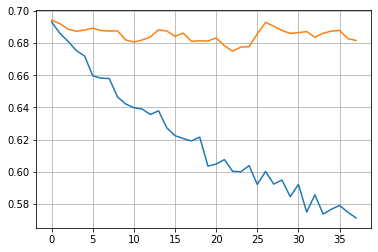

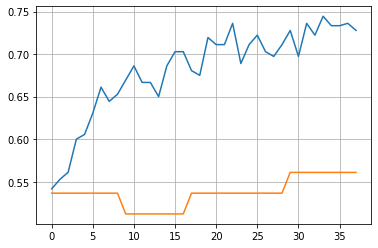

2/2 [==============================] - 1s 328ms/step - loss: 0.5683 - accuracy: 0.6818
Accuracy: 0.6818181872367859


accuracy    0.633838
dtype: float64

In [ ]:
N_EPOCAS = 60
kfold = KFold(n_splits=10, shuffle=True)
acc = []
fold = 1
directory_checkpoint = "tfm/checkpoints/impacto_tag_s_n_only_fin/"
for train, test in kfold.split(dataset_labels.body_no_entities):
    
    fold_train_x = dataset_labels.body_no_entities.values[train]
    textos_train = tokenizer(fold_train_x.tolist(), padding="max_length", truncation=True, return_tensors="tf")
     
    fold_train_y = dataset_labels.impacto_tag_s_n.values[train]
            
    model_checkpoint_callback = ModelCheckpoint(
        filepath=f'{directory_checkpoint}/fold_{fold}',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min')
    
    # Para cada Fold se entrena de nuevo
    model = TFBertForSequenceClassification.from_pretrained(checkpoint, num_labels=N_LABELS)
    model.layers[0].trainable=False
    model.layers[-1].activation=tf.keras.activations.softmax
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )

    print(f"Starting with Fold {fold}...")

    hist = model.fit(
        textos_train.data,
        fold_train_y,
        validation_split=0.1,
        epochs=N_EPOCAS,
        callbacks=[model_checkpoint_callback, early_stopping]
        )
    
    fold_test_x = dataset_labels.body_no_entities.values[test]
    textos_test = tokenizer(fold_test_x.tolist(), padding="max_length", truncation=True, return_tensors="tf")
    
    fold_test_y = dataset_labels.impacto_tag_s_n.values[test]

    fig = plt.figure(figsize=(20,10))
    plt.title("Train - Validation Loss")
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    fig = plt.figure(figsize=(20,10))
    plt.title("Train - Validation Accuracy")
    plt.plot(hist.history['accuracy'], label='train')
    plt.plot(hist.history['val_accuracy'], label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    model.load_weights(f'{directory_checkpoint}/fold_{fold}')
    i_acc  = model.evaluate(textos_test.data, fold_test_y)
    print("Accuracy:", i_acc[1])
    acc.append(i_acc[1])
    
    fold += 1
result = pd.DataFrame({'accuracy':acc})
result.mean()

In [ ]:
result

,accuracy
0,0.600000
1,0.533333
2,0.511111
3,0.755556
4,0.711111
5,0.681818
6,0.477273
7,0.704545
8,0.681818
9,0.681818


In [ ]:
result.mean()

accuracy    0.633838
dtype: float64